# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [22]:
import glob
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [23]:
region = "background"

In [24]:
input_gisaid_files = glob.glob(f'h3n2/data/raw/background/*.xls')

#### Outputs



In [25]:
export_augur = f'h3n2/data/clean/{region}_clean.tsv'

### Parameters

## Load raw data from GISAID

In [26]:
# Read each file into a dataframe
dfs = [pd.read_excel(file) for file in input_gisaid_files]

# Join all dataframes into one
meta_raw = pd.concat(dfs, ignore_index=True)
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_8636532,EPI1955366|3030724830_ZZYV98CM_v1_1,EPI1955367|3030724830_ZZYV98CM_v1_2,EPI1955365|3030724830_ZZYV98CM_v1_3,EPI1955369|3030724830_ZZYV98CM_v1_4,EPI1955362|3030724830_ZZYV98CM_v1_5,EPI1955368|3030724830_ZZYV98CM_v1_6,EPI1955364|3030724830_ZZYV98CM_v1_7,EPI1955363|3030724830_ZZYV98CM_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_8636540,EPI1955426|3030724884_ZZYV98R0_v1_1,EPI1955427|3030724884_ZZYV98R0_v1_2,EPI1955425|3030724884_ZZYV98R0_v1_3,EPI1955429|3030724884_ZZYV98R0_v1_4,EPI1955422|3030724884_ZZYV98R0_v1_5,EPI1955428|3030724884_ZZYV98R0_v1_6,EPI1955424|3030724884_ZZYV98R0_v1_7,EPI1955423|3030724884_ZZYV98R0_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_8636544,EPI1955457|3030724885_ZZYV98R2_v1_1,EPI1955458|3030724885_ZZYV98R2_v1_2,EPI1955456|3030724885_ZZYV98R2_v1_3,EPI1955460|3030724885_ZZYV98R2_v1_4,EPI1955453|3030724885_ZZYV98R2_v1_5,EPI1955459|3030724885_ZZYV98R2_v1_6,EPI1955455|3030724885_ZZYV98R2_v1_7,EPI1955454|3030724885_ZZYV98R2_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_8636545,EPI1955465|3030724828_ZZYV98CI_v1_1,EPI1955466|3030724828_ZZYV98CI_v1_2,EPI1955464|3030724828_ZZYV98CI_v1_3,EPI1955468|3030724828_ZZYV98CI_v1_4,EPI1955461|3030724828_ZZYV98CI_v1_5,EPI1955467|3030724828_ZZYV98CI_v1_6,EPI1955463|3030724828_ZZYV98CI_v1_7,EPI1955462|3030724828_ZZYV98CI_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_8636553,EPI1955515|3030724815_ZZYV98BN_v1_1,EPI1955516|3030724815_ZZYV98BN_v1_2,EPI1955514|3030724815_ZZYV98BN_v1_3,EPI1955518|3030724815_ZZYV98BN_v1_4,EPI1955513|3030724815_ZZYV98BN_v1_5,EPI1955517|3030724815_ZZYV98BN_v1_6,EPI1955928|3030724815_ZZYV98BN_v1_7,EPI1955927|3030724815_ZZYV98BN_v1_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Keep only the columns we are interested in.

In [27]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [28]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [29]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [30]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Louisiana/02/2021,2021-12-03,EPI_ISL_8636532,North America / United States / Louisiana,Human,Centers for Disease Control and Prevention,Louisiana Department of Health and Hospitals,h3n2_flu
1,A/Iowa/14/2021,2021-12-05,EPI_ISL_8636540,North America / United States / Iowa,Human,Centers for Disease Control and Prevention,Iowa State Hygienic Laboratory,h3n2_flu
2,A/Iowa/15/2021,2021-12-06,EPI_ISL_8636544,North America / United States / Iowa,Human,Centers for Disease Control and Prevention,Iowa State Hygienic Laboratory,h3n2_flu
3,A/Louisiana/01/2021,2021-12-03,EPI_ISL_8636545,North America / United States / Louisiana,Human,Centers for Disease Control and Prevention,Louisiana Department of Health and Hospitals,h3n2_flu
4,A/Kansas/04/2021,2021-12-01,EPI_ISL_8636553,North America / United States / Kansas,Human,Centers for Disease Control and Prevention,Kansas Department of Health and Environment,h3n2_flu
5,A/Tennessee/16/2021,2021-12-04,EPI_ISL_8636558,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu
6,A/Michigan/22/2021,2021-12-02,EPI_ISL_8636560,North America / United States / Michigan,Human,Centers for Disease Control and Prevention,Michigan Department of Community Health,h3n2_flu
7,A/Tennessee/15/2021,2021-12-04,EPI_ISL_8636565,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu
8,A/New Hampshire/07/2021,2021-12-02,EPI_ISL_8636568,North America / United States / New Hampshire,Human,Centers for Disease Control and Prevention,New Hampshire Public Health Laboratories,h3n2_flu
9,A/Tennessee/17/2021,2021-12-05,EPI_ISL_8636578,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu


## Parse metadata

### Parse country

In [31]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [32]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Louisiana/02/2021,2021-12-03,EPI_ISL_8636532,North America / United States / Louisiana,Human,Centers for Disease Control and Prevention,Louisiana Department of Health and Hospitals,h3n2_flu,North America,United States
1,A/Iowa/14/2021,2021-12-05,EPI_ISL_8636540,North America / United States / Iowa,Human,Centers for Disease Control and Prevention,Iowa State Hygienic Laboratory,h3n2_flu,North America,United States
2,A/Iowa/15/2021,2021-12-06,EPI_ISL_8636544,North America / United States / Iowa,Human,Centers for Disease Control and Prevention,Iowa State Hygienic Laboratory,h3n2_flu,North America,United States
3,A/Louisiana/01/2021,2021-12-03,EPI_ISL_8636545,North America / United States / Louisiana,Human,Centers for Disease Control and Prevention,Louisiana Department of Health and Hospitals,h3n2_flu,North America,United States
4,A/Kansas/04/2021,2021-12-01,EPI_ISL_8636553,North America / United States / Kansas,Human,Centers for Disease Control and Prevention,Kansas Department of Health and Environment,h3n2_flu,North America,United States
5,A/Tennessee/16/2021,2021-12-04,EPI_ISL_8636558,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu,North America,United States
6,A/Michigan/22/2021,2021-12-02,EPI_ISL_8636560,North America / United States / Michigan,Human,Centers for Disease Control and Prevention,Michigan Department of Community Health,h3n2_flu,North America,United States
7,A/Tennessee/15/2021,2021-12-04,EPI_ISL_8636565,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu,North America,United States
8,A/New Hampshire/07/2021,2021-12-02,EPI_ISL_8636568,North America / United States / New Hampshire,Human,Centers for Disease Control and Prevention,New Hampshire Public Health Laboratories,h3n2_flu,North America,United States
9,A/Tennessee/17/2021,2021-12-05,EPI_ISL_8636578,North America / United States / Tennessee,Human,Centers for Disease Control and Prevention,Tennessee Department of Health Laboratory-Nash...,h3n2_flu,North America,United States


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [33]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [34]:
meta_working.head(n=10)['strain']

0        A/Louisiana/02/2021
1             A/Iowa/14/2021
2             A/Iowa/15/2021
3        A/Louisiana/01/2021
4           A/Kansas/04/2021
5        A/Tennessee/16/2021
6         A/Michigan/22/2021
7        A/Tennessee/15/2021
8    A/New_Hampshire/07/2021
9        A/Tennessee/17/2021
Name: strain, dtype: object

### Deduplicate strains

In [35]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 77872 records.
	There were 66654 unique records.
	After cleaning, there were 66654 records remaining.


### Clean up countries

In [36]:
meta_working['country'].value_counts(dropna=False)

country
United States                       15775
United Kingdom                       5268
Spain                                4299
Russian Federation                   3180
Canada                               3165
                                    ...  
Tajikistan                              1
Aruba                                   1
Grenada                                 1
Cayman Islands                          1
Saint Vincent and the Grenadines        1
Name: count, Length: 152, dtype: int64

In [37]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {'Saint Kitts and Nevis, Federation of': 'Saint Kitts and Nevis',
         'Congo, the Democatic Republic of': 'DRC',
         'Tanzania, United Republic of': 'Tanzania',
         "Lao, People's Democratic Republic": 'Laos',
         'Korea, Republic of': 'South Korea',
         'Hong Kong (SAR)': 'Hong Kong',
         'Iran, Islamic Republic of': 'Iran',
         'Palestinian Territory': 'Palestine',
         "Macedonia, the former Yogoslav Republic of": 'Macedonia',
         'Moldova, Republic of  ': 'Moldova',
         'Saint Kitts and Nevis, Federation of': 'Saint Kitts and Nevis'}
    ))

In [38]:
meta_working['country'].value_counts(dropna=False)

country
United States                       15775
United Kingdom                       5268
Spain                                4299
Russian Federation                   3180
Canada                               3165
                                    ...  
Tajikistan                              1
Aruba                                   1
Grenada                                 1
Cayman Islands                          1
Saint Vincent and the Grenadines        1
Name: count, Length: 152, dtype: int64

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [39]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [40]:
meta_clean['strain'].count()

66654

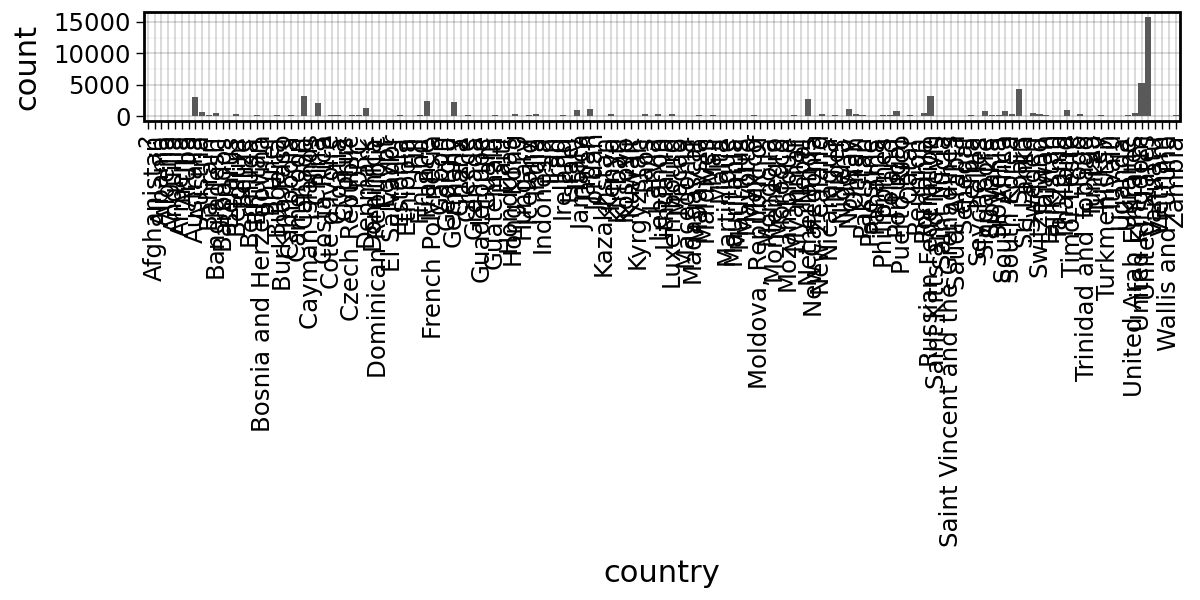

In [41]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [42]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Afghanistan (n=56)
A/Afghanistan/5373/2021
A/Afghanistan/4839/2021
A/Afghanistan/5317/2021
A/Afghanistan/5022/2021
A/Afghanistan/4966/2021
A/Afghanistan/4900/2021
A/Afghanistan/4862/2021
A/Afghanistan/4961/2021
A/Afghanistan/4980/2021
A/Afghanistan/5311/2021
A/Afghanistan/4982/2021
A/Afghanistan/4819/2021
A/Afghanistan/4837/2021
A/Afghanistan/4979/2021
A/Afghanistan/4851/2021
A/Afghanistan/6100/2021
A/Afghanistan/4820/2021
A/Afghanistan/4834/2021
A/Afghanistan/5113/2021
A/Afghanistan/4903/2021
A/Afghanistan/5142/2021
A/Afghanistan/5202/2021
A/Afghanistan/5206/2021
A/Afghanistan/4960/2021
A/Afghanistan/4955/2021
A/Afghanistan/4988/2021
A/Afghanistan/5117/2021
A/Afghanistan/5301/2021
A/Afghanistan/4841/2021
A/Afghanistan/6412/2023
A/Afghanistan/5931/2023
A/Afghanistan/6262/2023
A/Afghanistan/6250/2023
A/Afghanistan/5930/2023
A/Afghanistan/5803/2023
A/Afghanistan/5687/2023
A/Afghanistan/5614/2023
A/Afghanistan/5800/2023
A/Afghanistan/5791/2023
A/Afghanistan/6257/2023
A/Afghanistan/6411/20